# set Random seed
torch.manual_seed(seed)
np.random.seed(seed)

In [1]:
# set Random seed
seed = 0
import torch
import numpy as np
torch.manual_seed(seed)
np.random.seed(seed)
import os
from torch import nn
import torch, transformers
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
from sklearn import metrics
import re,pickle,random,json,os
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertModel,BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,Dataset
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import math 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F
device = 'cuda'

In [2]:
import argparse
import json
from operator import add
from typing import List, Optional, Tuple, Union

import numpy as np
import torch
from classification_head import ClassificationHead
from torch import nn
from tqdm import trange

from transformers import GPT2LMHeadModel, GPT2Tokenizer
#from transformers.file_utils import cached_path
from cached_path import cached_path

In [3]:
data =pd.read_csv("data_train.csv") 
del data['Unnamed: 0']
data['act'] = data['act']-1
a=data.loc[data.act==1,['dialog','act']][:3200]
b=data.loc[data.act==3,['dialog','act']][:3200]
c= data.loc[data.act==0,['dialog','act']][:3200]
d =data.loc[data.act==2,['dialog','act']][:3200]

data = pd.concat([a,b,c,d],ignore_index = True)
train_size = 0.85
train_dataset = data.sample(frac=train_size,random_state=200)
valid_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


validdd_dataset = valid_dataset.sample(frac=0.5,random_state=200)
test_dataset = valid_dataset.drop(validdd_dataset.index).reset_index(drop=True)
valid_dataset =  validdd_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("valid Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (12800, 2)
TRAIN Dataset: (10880, 2)
valid Dataset: (960, 2)
TEST Dataset: (960, 2)


In [4]:
data.act.value_counts()

act
1    3200
3    3200
0    3200
2    3200
Name: count, dtype: int64

In [5]:
test_dataset.act.value_counts()

act
2    263
0    254
3    222
1    221
Name: count, dtype: int64

In [6]:
valid_dataset

,dialog,act
0,"Terrific ! B . A . , again and again-B . A .",0
1,"Well , he's very tall and handsome .",3
2,What else do you see ? Will I be successful ?...,1
3,But it's really too important to me .,3
4,Thank you very much .,3
...,...,...
955,Just remember that red means absolutely no pa...,2
956,"hi , come on in . Can I take your coat ?",2
957,Good idea !,3
958,Very good ! It pumps blood throughout the bod...,1


In [7]:

class CustomDataset(Dataset):
    def __init__(self, df):
        self.data =df 
        self.data_list, self.label_list = self.load_data()
        
    def __len__(self):
        return len(self.label_list)
    def load_data(self):
        data_list = self.data['dialog']
        label_list = self.data['act']
        
        return data_list, label_list 
    def __getitem__(self, index):
        data = self.data_list[index]
        label = torch.tensor(self.label_list[index], dtype = torch.long)
        return data, label
        

In [8]:
#
training_set = CustomDataset(train_dataset)

test_set = CustomDataset(test_dataset)

validation_set = CustomDataset(valid_dataset)

batch_size =24
train_dl = DataLoader(training_set,batch_size=batch_size, shuffle = True)
validation_dl = DataLoader(validation_set,batch_size=batch_size,shuffle = False)
test_dl = DataLoader(test_set,batch_size=batch_size,shuffle = False)


In [9]:
data, label= next(iter(train_dl))

In [10]:
data

('Can you study with the radio on ? ',
 ' We ate a lot of things . We played games and gave gifts to Jessie . We had a lot of fun . ',
 ' I can accept that . ',
 ' Yep ! The nick name for your zone , address , gender and so on . Some of them are privacy , so you have the right to keep secret here . ',
 ' What ? ',
 ' I Believe I will . Look for me near the lake . ',
 ' I can do that . ',
 ' Yes , doctor . ( The doctor examines the patient ) ',
 ' so how many people are coming for the dinner tonight ? ',
 ' Did you register yet ? ',
 ' sure , I have a part-time job as a bartender . ',
 ' Ok . That sounds like a deal . ',
 " I don't think so . That way it would lose all the charm . I want it to be a surprise . I want to show her that I care about her and I hope our friendship will last . ",
 " No , don't try to tempt me . I'm becoming chubby , and I have to slender down . ",
 ' Do you know where they will go on their honeymoon ? ',
 ' All right , see you then . ',
 " Yes , I think I am .

In [11]:
label

tensor([1, 0, 3, 0, 1, 3, 3, 3, 2, 1, 0, 3, 3, 3, 1, 3, 2, 2, 0, 0, 2, 1, 3, 3])

In [12]:
from transformers import BertTokenizerFast, BertModel

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #참고로 'bert-base-uncased' 모델은 버트의 가장 기본적인 모델을 의미
        #uncased는 모든 문장을 소문자로 대체하겠다는 것 
        
        self.classifier  = nn.Sequential(
            nn.ReLU(),
            nn.Linear(768,4)
        )
        
        
    def forward(self,inputs):
        
        #print(inputs['input_ids'].shape)  
        bert_outputs = self.bert(**inputs,return_dict =True)
        #print("bert_outputs",bert_outputs)
        pooler_output = bert_outputs.last_hidden_state[:,0]
        # bert_outputs.last_hidden_state[:,0] -> 첫번째니까 [cls] 토큰의
        # embedding만을 뽑아내어 classification task를 위한 텐서로 변환한다? 
        #print("pooler_output",pooler_output.shape)
        
        logits = self.classifier(pooler_output)
        #print("logits",logits.shape)
        
        return logits


tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = Model().to(device)



In [13]:


n_epochs = 100
train_loss_per_epoch = []
train_acc_per_epoch = []
test_loss_per_epoch =[]
test_acc_per_epoch = []
best_valid_loss =float('inf')

In [14]:
lr = 1e-6
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)



for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0.0
    train_n_samples = 0
    
    print('Epoch', epoch)
    
    model.train()
    for batch_idx,batch in enumerate(tqdm(train_dl, ncols=80, desc='train_step')):
        
        data, y_true = batch
        data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)
        
        data = { k: v.to(device) for k, v in data.items() }
        y_true = y_true.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        
        optimizer.step()
        train_acc += torch.sum(y_pred.argmax(1) == y_true).item()
        train_n_samples += len(y_true)
    
    train_acc = (train_acc / train_n_samples) * 100.
    train_acc_per_epoch.append(train_acc)
    train_loss = train_loss/len(train_dl)
    train_loss_per_epoch.append(train_loss)
    # test step

    test_acc = 0.0
    test_n_samples = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for batch_idx,batch in enumerate(tqdm(validation_dl, ncols=80, desc='valid_step')):
            data, y_true = batch
            data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)
            
            data = { k: v.to(device) for k, v in data.items() }
            y_true = y_true.to(device)
            y_pred = model(data)
            
            loss = loss_fn(y_pred, y_true)
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.item() - test_loss))

            test_acc += torch.sum(y_pred.argmax(1) == y_true).item()
            test_n_samples += len(y_true)
    test_acc = (test_acc / test_n_samples) * 100.
    test_acc_per_epoch.append(test_acc)
    test_loss = test_loss/len(test_dl)
    test_loss_per_epoch.append(test_loss)
    

        
    print('############# Epoch {}  Done   #############\n'.format(epoch))
    print('###train_loss:',train_loss,'###valid_loss:',test_loss)
    print('###train_acc:',train_acc,'###valid_acc:',test_acc)
    #Early stopping 
    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        if epoch !=0 :
            torch.save(model, 'epoch{}_bert_model.pt'.format(epoch))    



Epoch 0


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 0  Done   #############

###train_loss: 0.002444510305975119 ###valid_loss: 0.018977584354579444
###train_acc: 57.7297794117647 ###valid_acc: 73.4375
Epoch 1


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 1  Done   #############

###train_loss: 0.0016141545258332448 ###valid_loss: 0.015529669504612677
###train_acc: 73.6764705882353 ###valid_acc: 76.45833333333333
Epoch 2


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 2  Done   #############

###train_loss: 0.0014111598616601438 ###valid_loss: 0.01481732158921659
###train_acc: 75.6341911764706 ###valid_acc: 76.97916666666667
Epoch 3


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 3  Done   #############

###train_loss: 0.0013211155999786964 ###valid_loss: 0.014282420082017775
###train_acc: 77.27941176470588 ###valid_acc: 78.85416666666667
Epoch 4


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 4  Done   #############

###train_loss: 0.0012615120710047075 ###valid_loss: 0.014056769534945493
###train_acc: 78.08823529411765 ###valid_acc: 78.85416666666667
Epoch 5


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 5  Done   #############

###train_loss: 0.0012057038350226882 ###valid_loss: 0.013897100826725368
###train_acc: 79.31066176470588 ###valid_acc: 79.6875
Epoch 6


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 6  Done   #############

###train_loss: 0.0011631089794701473 ###valid_loss: 0.013710043178871275
###train_acc: 80.01838235294117 ###valid_acc: 79.58333333333333
Epoch 7


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 7  Done   #############

###train_loss: 0.001121899978828105 ###valid_loss: 0.013672503894194962
###train_acc: 80.96507352941177 ###valid_acc: 80.0
Epoch 8


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 8  Done   #############

###train_loss: 0.0010882599132561728 ###valid_loss: 0.01381871766410768
###train_acc: 81.36029411764706 ###valid_acc: 79.6875
Epoch 9


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 9  Done   #############

###train_loss: 0.0010571744950208539 ###valid_loss: 0.01362500420305878
###train_acc: 82.15073529411765 ###valid_acc: 80.20833333333334
Epoch 10


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 10  Done   #############

###train_loss: 0.0010322831363904607 ###valid_loss: 0.01348687360994517
###train_acc: 82.42647058823529 ###valid_acc: 79.79166666666667
Epoch 11


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 11  Done   #############

###train_loss: 0.0009925864857687045 ###valid_loss: 0.013739523845724761
###train_acc: 83.47426470588235 ###valid_acc: 80.10416666666667
Epoch 12


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 12  Done   #############

###train_loss: 0.0009647181532724268 ###valid_loss: 0.013793810070492324
###train_acc: 83.86948529411765 ###valid_acc: 80.72916666666666
Epoch 13


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 13  Done   #############

###train_loss: 0.0009402602670036162 ###valid_loss: 0.013736576051451265
###train_acc: 84.33823529411765 ###valid_acc: 80.52083333333333
Epoch 14


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 14  Done   #############

###train_loss: 0.0009113988517756558 ###valid_loss: 0.013910111873410643
###train_acc: 85.0091911764706 ###valid_acc: 80.52083333333333
Epoch 15


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 15  Done   #############

###train_loss: 0.0008795874218216373 ###valid_loss: 0.01386243088636547
###train_acc: 85.63419117647058 ###valid_acc: 81.5625
Epoch 16


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

############# Epoch 16  Done   #############

###train_loss: 0.0008540540570254221 ###valid_loss: 0.014004499521106476
###train_acc: 86.11213235294117 ###valid_acc: 81.04166666666667
Epoch 17


train_step:   0%|                                       | 0/454 [00:00<?, ?it/s]

KeyboardInterrupt: 

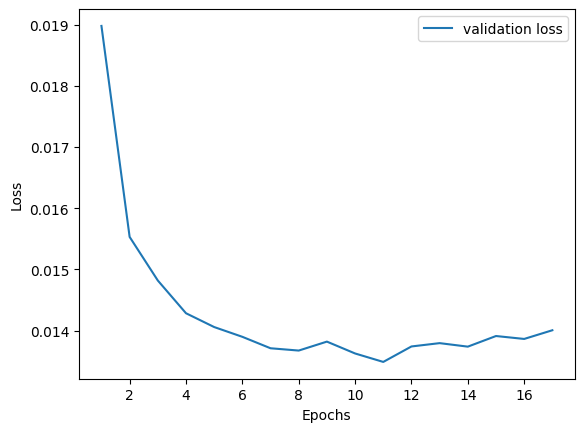

In [16]:
from matplotlib import pyplot as plt
epochs = range(1,epoch+1 )
fig, ax = plt.subplots()
#ax.plot(epochs,np.array(train_loss_per_epoch),label ='training loss')
ax.plot(epochs, np.array(test_loss_per_epoch), label = 'validation loss' )
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

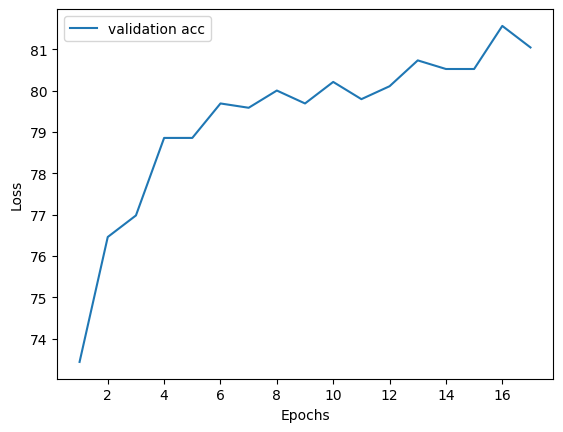

In [17]:
from matplotlib import pyplot as plt
epochs = range(1,epoch+1 )
fig, ax = plt.subplots()
#ax.plot(epochs,np.array(train_acc_per_epoch),label ='training acc')
ax.plot(epochs, np.array(test_acc_per_epoch), label = 'validation acc' )
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [18]:
test_acc = 0.0
test_n_samples = 0

model.eval()
with torch.no_grad():
    for batch_idx,batch in enumerate(tqdm(test_dl, ncols=80, desc='valid_step')):
        data, y_true = batch
        data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)
        
        data = { k: v.to(device) for k, v in data.items() }
        y_true = y_true.to(device)
        y_pred = model(data)
        test_acc += torch.sum(y_pred.argmax(1) == y_true).item()
        test_n_samples += len(y_true)
test_acc = (test_acc / test_n_samples) * 100.
test_acc

valid_step:   0%|                                        | 0/40 [00:00<?, ?it/s]

81.14583333333333